<a href="https://colab.research.google.com/github/matthewkim0617/scotiabank_ml_project/blob/main/ML_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## INTRODUCTION

The goal of this notebook to develop a machine learning model to predict daily stock prices for a given ten stocks. Then select top three stocks based on the prediction accruacy, allocate $10,000 investment among them using any weighting strategy, and create a decision-making tool to generate daily trading signals (buy, sell, or hold) solely based on forecasted future prices from the machine learning model.




## 1) Import Required Models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing_extensions import final
import os

## 2) Data Preparation for LSTM

The prepare_lstm_data function creates sequences of 60 days (lookback period)


*   The "load_data" function will consolidate all the stock csv files
*   The prepare_lstm_data function creates sequences of lookback period for the closing stock prices for LSTM.
*  Closing Prices are normalized using MinMaxScaler to stabilize training.
*   The target scaler is used to inverse-transform predictions for evaluation and signal generation.


In [ ]:
def load_data(directory_path):
    stock_data = {}
    tickers = []
    for file in os.listdir(directory_path):
        if file.endswith('.csv'):
            stock_name = file.replace('.csv', '')
            df = pd.read_csv(os.path.join(directory_path, file), parse_dates=['Date'])
            df.sort_values('Date', inplace=True)
            stock_data[stock_name] = df
            tickers.append(stock_name)
    return stock_data, tickers



def prepare_lstm_data(df, look_back):
    if df.empty or len(df) < look_back:
        return None, None, None, None, None

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler

## 3)LSTM Model:
* The model consists of two LSTM layers (50 units each) with dropout (0.2) to prevent overfitting, followed by a Dense layer for the output.
* Trained with the Adam optimizer and Mean Squared Error (MSE) loss.
* Standard epoch of 50 and batch size of 32

In [ ]:
def build_lstm_model(look_back):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def train_lstm_model(model, X_train, y_train, epochs=50, batch_size=32):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

# Evaluate model performance
def evaluate_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform([y_test])
    rmse = np.sqrt(np.mean((predictions - y_test_scaled.T)**2))
    return rmse, predictions


## 4) Weight Strategy

After determining the top three stocks, I've determined the weights for these stocks using standard Modern Portfolio Theory based on the historical data.

In [ ]:
#Portfolio Optimization (MPT-inspired)
def portfolio_optimization(predicted_returns, cov_matrix):
    def objective(weights):
        port_return = np.sum(predicted_returns * weights) * 252  # Annualized return
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
        return -port_return / port_volatility  # Negative Sharpe ratio (maximize)

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(predicted_returns)))
    result = minimize(objective, np.array([1/len(predicted_returns)]*len(predicted_returns)),
                     method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

## 5) Signal Generation:

Signal is determined using one of the technical analysis, Rolling Momentum and Trend.

In [ ]:
def generate_trading_signals(predictions, threshold=0.005, momentum_window=3):
    signals = []
    momentum = []

    for i in range(1, len(predictions)):
        change = (predictions[i] - predictions[i-1]) / predictions[i-1]
        momentum.append(change)

        # Use rolling momentum and trend
        if i >= momentum_window:
            avg_momentum = np.mean(momentum[-momentum_window:])
            recent_trend = predictions[i] - predictions[i - momentum_window]

            if avg_momentum > threshold and recent_trend > 0:
                signals.append('buy')
            elif avg_momentum < -threshold and recent_trend < 0:
                signals.append('sell')
            else:
                signals.append('hold')
        else:
            signals.append('hold')

    signals.insert(0, 'hold')
    return signals

## 6) Baseline Strategy

It will use the initial weight, and maintain the holding for next 365 days (or 255 trading days).

In [22]:
def baseline_strategy(data, tickers, forecast_days, weights):
    initial_investment = 10000  # $10,000
    holdings = {ticker: 0 for ticker in tickers}
    portfolio_value = [initial_investment]

    for day in range(forecast_days):
        daily_return = 0
        for i, ticker in enumerate(tickers):
            weight = weights[i]
            actual_prices = data[ticker]['Close'].values[forecast_days:]
            actual_returns = (actual_prices[1:] - actual_prices[:-1]) / actual_prices[:-1]
            daily_return += weight * actual_returns[day]
        portfolio_value.append(portfolio_value[-1] * (1 + daily_return))

    return portfolio_value


## 7) Main Execution

In [29]:
def main():
    # Train and evaluate LSTM models
    models = {}
    rmses = {}
    predictions_dict = {}
    scalers = {}
    look_back = 60
    start_date = datetime(2014, 1, 1)
    end_date = datetime(2019, 1, 1)

    #Data Preparation
    initial_data, tickers = load_data('/content/drive/MyDrive/Data')
    mid_data = {stock_name: df[['Date','Close', 'Volume']] for stock_name, df in initial_data.items()}
    final_data = {stock_name: df[(df['Date'] >= start_date) &  (df['Date'] <= end_date)] for stock_name, df in mid_data.items()}
    fut_data = {stock_name: df[(df['Date'] > end_date) ] for stock_name, df in mid_data.items()}

    for ticker in tickers:
      X_train, X_test, y_train, y_test, scaler = prepare_lstm_data(final_data[ticker], look_back)
      model = build_lstm_model(look_back)
      model = train_lstm_model(model, X_train, y_train)
      rmse, predictions = evaluate_model(model, X_test, y_test, scaler)

      models[ticker] = model
      rmses[ticker] = rmse
      scalers[ticker] = scaler

      fut_X_train, fut_X_test, fut_y_train, fut_y_test, fut_scaler = prepare_lstm_data(fut_data[ticker], look_back)
      fut_X = np.concatenate((fut_X_train, fut_X_test))
      fut_y = np.concatenate((fut_y_train, fut_y_test))
      fut_rmse, fut_predictions = evaluate_model(model, fut_X, fut_y, fut_scaler)
      predictions_dict[ticker] = fut_predictions

    # Select top 3 stocks
    selected_stocks = sorted(rmses, key=rmses.get)[:3]
    print(f"Selected stocks: {selected_stocks}")



    # Calculate actual returns from the  and covariance
    hist_returns = []
    returns_data = []
    test_size = len(y_test)
    portfolio_signals = {}
    portfolio_predictions = {}



    for stock in selected_stocks:
      actual_prices = final_data[stock]['Close'].values[:test_size]
      returns = (actual_prices[1:] - actual_prices[:-1]) / actual_prices[:-1]
      hist_returns.append(np.mean(returns))
      returns_data.append(returns.flatten())

    cov_matrix = np.cov(returns_data)

    # Optimize portfolio weights
    weights = portfolio_optimization(hist_returns, cov_matrix)
    print(f"Portfolio weights: {dict(zip(selected_stocks, weights))}")

    # Generate trading signals
    for stock in selected_stocks:
      signals = generate_trading_signals(predictions_dict[stock].flatten())
      portfolio_signals[stock] = signals

    signal_counts = {}
    for stock, signals in portfolio_signals.items():
            signal_counts[stock] = {
                'buy': signals.count('buy'),
                'sell': signals.count('sell'),
                'hold': signals.count('hold')
            }
    signal_df = pd.DataFrame.from_dict(signal_counts, orient='index')
    print("\nSignal Counts per Stock:")
    print(signal_df)




    #Testing the signals
    forecast_days = len(fut_y)
    initial_investment = 10000  # $100,000
    holdings = {ticker: 0 for ticker in tickers}

    portfolio_value = 0
    pv_list = [initial_investment]

    for i, stock in enumerate(selected_stocks):
      portfolio_value += weights[i]*initial_investment

    for day in range(forecast_days):
        daily_return = 0
        for i, stock in enumerate(selected_stocks):
            weight = weights[i]
            signal = portfolio_signals[stock][day]
            predicted_price = predictions_dict[stock][day]

            if signal == 'Buy' and holdings[stock] == 0:
                shares_to_buy = (portfolio_value * weight) / predicted_price
                holdings[stock] = shares_to_buy
            elif signal == 'Sell' and holdings[stock] > 0:
                portfolio_value += holdings[stock] * predicted_price
                holdings[stock] = 0

            actual_prices = final_data[stock]['Close'].values[forecast_days:]
            actual_returns = (actual_prices[1:] - actual_prices[:-1]) / actual_prices[:-1]
            daily_return += weight * actual_returns[day]
            portfolio_value *= (1 + daily_return)
        pv_list.append(portfolio_value)

    print(f"Final Portfolio Value: ${portfolio_value:.2f}")


    baseline_pv = baseline_strategy(final_data, selected_stocks, forecast_days, weights)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(pv_list,label='LSTM Strategy Portfolio')
    plt.plot(baseline_pv, label='Baseline Strategy Portfolio')
    plt.xlabel('Days')
    plt.ylabel('Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.legend()
    plt.grid(True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Selected stocks: ['st8', 'st5', 'st10']
Portfolio weights: {'st8': np.float64(0.0), 'st5': np.float64(0.9824603163521985), 'st10': np.float64(0.017539683647801625)}

Signal Counts per Stock:
      buy  sell  hold
st8    33    62   160
st5    31    50   174
st10   42    42   171
Final Portfolio Value: $8738.99


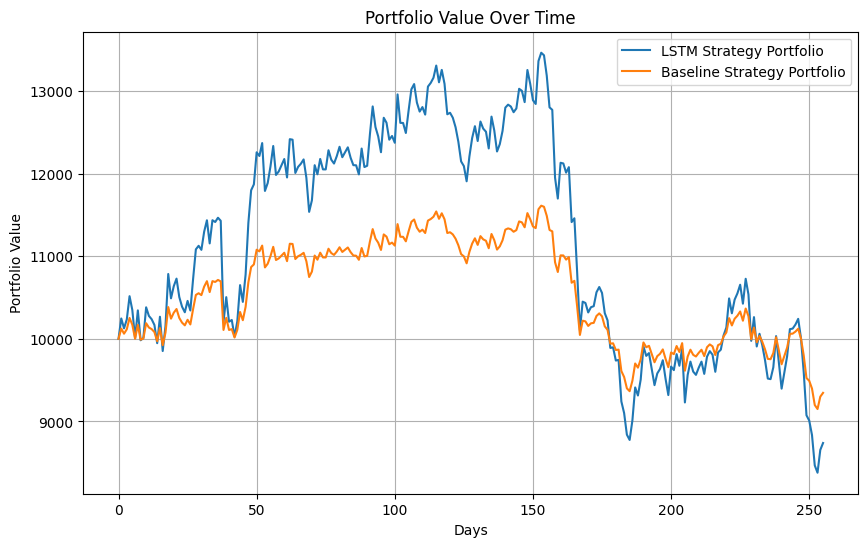

In [30]:
if __name__ == "__main__":
    main()